In [199]:
!pip install transformers 
!pip install evaluate
!pip install timm 
!pip install albumentations

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [2]:
str = 'a.jpg'
print(str[:-4])

a


In [7]:
from tqdm import tqdm
import cv2
import os

for file in tqdm(os.listdir('/kaggle/input/1-aiku-x-ybigta-datathon/dataset/train/train_source')): 
    cv2.imwrite(os.path.join('/kaggle/working/train_source', file), cv2.imread(os.path.join('/kaggle/input/1-aiku-x-ybigta-datathon/dataset/train/train_source', file)))
for file in tqdm(os.listdir('/kaggle/input/augmentation-picture/augmentation_picture')):
    cv2.imwrite(os.path.join('/kaggle/working/train_source', file[:-4]), cv2.imread(os.path.join('/kaggle/input/augmentation-picture/augmentation_picture', file)))

100%|██████████| 4647/4647 [05:35<00:00, 13.84it/s]


In [6]:
import os
os.mkdir('/kaggle/working/train_source')

       Unnamed: 0  image_id  \
0               0         1   
1               1         1   
2               2         1   
3               3         1   
4               4         1   
...           ...       ...   
80847       41097      9645   
80848       41098      9646   
80849       41107      9647   
80850       41108      9647   
80851       41109      9647   

                                               file_path  category_id     x  \
0              ./train_source/HT_TRAIN_000001_SH_000.jpg            3    65   
1              ./train_source/HT_TRAIN_000001_SH_000.jpg            2   418   
2              ./train_source/HT_TRAIN_000001_SH_000.jpg            2   399   
3              ./train_source/HT_TRAIN_000001_SH_000.jpg            2   347   
4              ./train_source/HT_TRAIN_000001_SH_000.jpg            2   330   
...                                                  ...          ...   ...   
80847  ./train_source/augmentation HT_TRAIN_004997_SH...            4     

### DATASET

In [43]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import pdb
import random

class DetectionDataset(Dataset):
    def __init__(self, root, meta_path, transform, image_processor, split='train', train_val_ratio=0.7):
        super().__init__()
        self.root = root
        self.split = split
        self.transform = transform
        self.image_processor = image_processor
        
        if split in ['train', 'val']:
            self.load_meta(meta_path, train_val_ratio)
        else:
            self.load_test_meta(meta_path)
    
    def load_test_meta(self, meta_path):
        raw_meta = pd.read_csv(meta_path)
        self.meta = []
        n = raw_meta.shape[0]
        
        for i in range(n):
            image_id = raw_meta['image_id'][i]
            image_path = raw_meta['file_path'][i]
            self.meta.append({'image_id': image_id, 'image_path': image_path})

    def load_meta(self, meta_path, train_val_ratio):
        raw_meta = pd.read_csv(meta_path)
        self.meta = []
        n = raw_meta.shape[0]
        image = Image.open(self.root + raw_meta['file_path'][0][1:])
        width, height = image.size
        
        n_list = list(range(n))
        random.shuffle(n_list)
        for i in n_list:
            image_id = raw_meta['image_id'][i]
            image_path = raw_meta['file_path'][i]
            category_id = raw_meta['category_id'][i]
            bbox = self.bbox_check((raw_meta['x'][i], raw_meta['y'][i], raw_meta['w'][i], raw_meta['h'][i]), width, height)
            area = bbox[2] * bbox[3]
            
            if image_id > len(self.meta):
                self.meta.append({
                    'image_id': image_id,
                    'image_path': image_path,
                    'objects': {
                        'category': [category_id],
                        'bbox': [bbox],
                        'area': [area],
                    }
                })
            else:
                self.meta[image_id - 1]['objects']['category'].append(category_id)
                self.meta[image_id - 1]['objects']['bbox'].append(bbox)
                self.meta[image_id - 1]['objects']['area'].append(area)
        
        n_samples = len(self.meta)
        n_train = int(n_samples * train_val_ratio)
        
        if self.split == 'train':
            self.meta = self.meta[:n_train]
        elif self.split == 'val':
            self.meta = self.meta[n_train:]
            
    def __getitem__(self, idx):
        if self.split == 'test':
            return self.get_testitem(idx)
        
        image = Image.open(self.root + self.meta[idx]['image_path'][1:])
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = self.transform(
            image=image, 
            bboxes=self.meta[idx]['objects']['bbox'],
            category=self.meta[idx]['objects']['category']
        )
        
        target = {
            "image_id": self.meta[idx]['image_id'], 
            "annotations": self.formatted_anns(self.meta[idx]['image_id'], 
                                               out['category'], 
                                               self.meta[idx]['objects']['area'], 
                                               out['bboxes']
                                              )
        }
        
        return self.image_processor(
            images=out['image'], 
            annotations=target, 
            return_tensors='pt'
        )
    
    def get_testitem(self, idx):
        return self.meta[idx]['image_id'], Image.open(self.root + self.meta[idx]['image_path'][1:]), self.meta[idx]['image_path']
    
    def bbox_check(self, bbox, width, height):
        x, y, w, h = bbox
        if x < 0.0:
            w -= x
            x = 0
        if x + w >= width:
            w -= (x + w) - width
        if y < 0.0:
            h -= y
            y = 0
        if y + h > height:
            h -= (y + h) - height
        return x, y, w, h            
        
    def formatted_anns(self, image_id, category, area, bbox):
        annotations = []
        for i in range(len(category)):
            annotations.append({
                'image_id': image_id,
                'category_id': category[i],
                'isCrowd': 0,
                'area': area[i],
                'bbox': bbox[i],
            })
        return annotations
    
    def visualize(self, idx):
        img_path = self.meta[idx]['image_path']
        img = Image.open(self.root + img_path[1:])
        draw = ImageDraw.Draw(img)
        
        for x, y, w, h in self.meta[idx]['objects']['bbox']:
            draw.rectangle((x, y, x + w, y + h), outline='red', width=1)
        
        return img
    
    def __len__(self):
        return len(self.meta)

In [55]:
import albumentations
import numpy as np
import torch
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

train_ds = DetectionDataset(
    '/kaggle/working',
    '/kaggle/input/all-source/train_source.csv',
    transform,
    image_processor,
)

val_ds = DetectionDataset(
    '/kaggle/working',
    '/kaggle/input/all-source/train_source.csv',
    transform,
    image_processor,
    split='val',
)

print('Load Dataset')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Load Dataset


### VISUALIZATION

6749


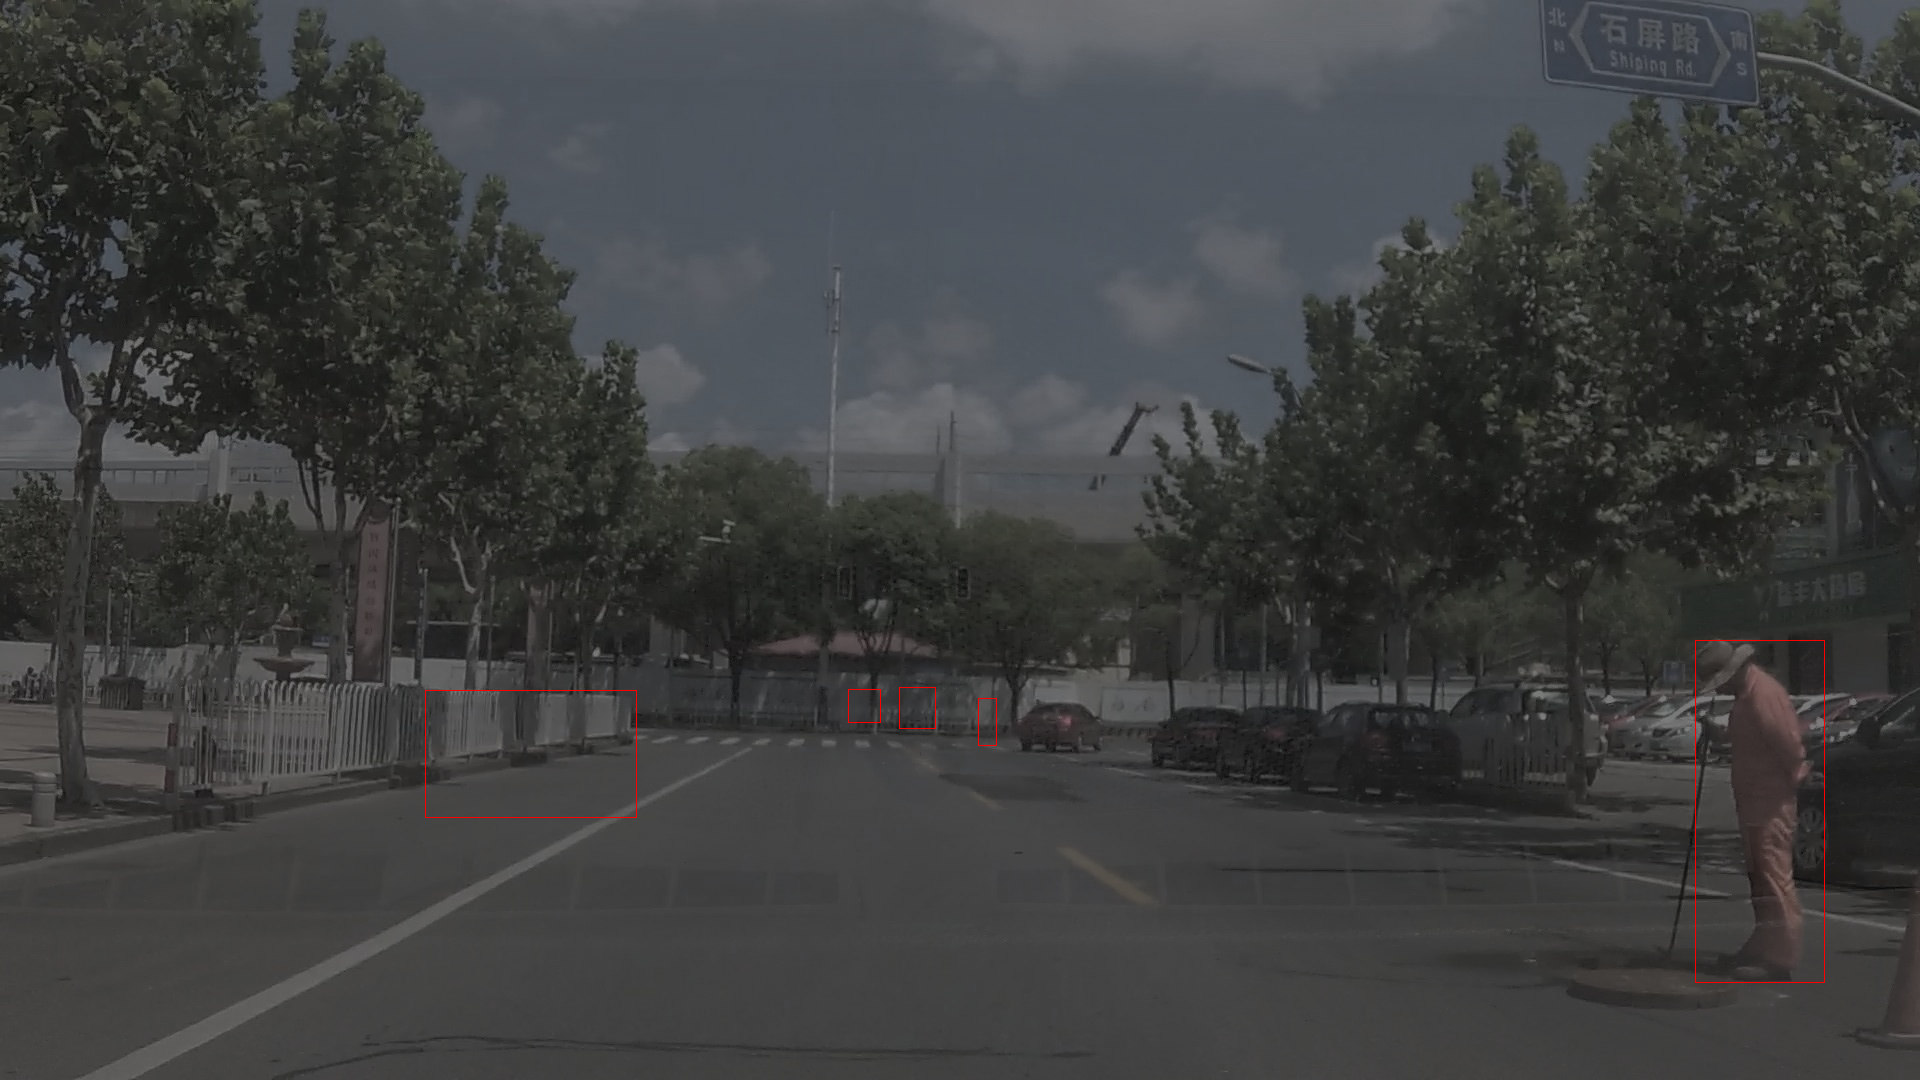

In [45]:
print(len(train_ds))
train_ds.visualize(600)


In [56]:
df = pd.read_csv('/kaggle/input/1-aiku-x-ybigta-datathon/dataset/category.csv')
n = df.shape[0]

id2label = {}
label2id = {}

for i in range(n):
    Id = int(df['category_id'][i])
    Name = df['name'][i]
    id2label[Id] = Name
    label2id[Name] = Id

print(id2label)
print(label2id)

{1: 'Pedestrian', 2: 'Cyclist', 3: 'Car', 4: 'Truck', 5: 'Tram ', 6: 'Tricycle'}
{'Pedestrian': 1, 'Cyclist': 2, 'Car': 3, 'Truck': 4, 'Tram ': 5, 'Tricycle': 6}


### MODEL

In [57]:
from transformers import AutoModelForObjectDetection

checkpoint = 'facebook/detr-resnet-50'

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

### TRAIN

In [58]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='/kaggle/working', # output_dir
    per_device_train_batch_size=16,
    num_train_epochs=10,
    fp16=True,
    logging_steps=200,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    evaluation_strategy='steps',
    eval_steps=300,
    load_best_model_at_end=True,
    save_steps=300
)

# 이 코드를 실행하기 위해서는 output_dir에 자신의 huggingface repo를 넣어줘야 합니다.

In [59]:
from huggingface_hub import notebook_login

notebook_login()

# 이 코드를 실행하기 위해서는 huggingface에서 자신의 write token이 필요합니다.

In [ ]:
from transformers import Trainer

def collate_fn(batch):
    pixel_values = [item["pixel_values"][0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"][0] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
)

trainer.train(resume_from_checkpoint='/kaggle/input/gamedf/checkpoint-1800')

# 이 코드를 실행하기 위해서는 wandb api token이 필요합니다.

Step,Training Loss,Validation Loss
2100,3.706400,3.266662


### VISUALIZATION

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# 이 코드를 실행하기 위해서는 huggingface에서 자신의 read token이 필요합니다.

In [ ]:
from transformers import AutoModelForObjectDetection
from tqdm import tqdm

name = './detr-resnet-50_finetuned_overflow'

image_processor = AutoImageProcessor.from_pretrained(name)
model = AutoModelForObjectDetection.from_pretrained(name).to('cuda')

submit_results = {
    'image_id': [],
    'file_path': [],
    'category_id': [],
    'x' : [],
    'y' : [],
    'w' : [],
    'h' : []
}

with torch.no_grad():
    for image_id, image, image_path in tqdm(test_ds):
        inputs = image_processor(images=image, return_tensors="pt").to('cuda')
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])
        results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]
        
        n = results['scores'].shape[0]
        
        prediction = ''
        for i in range(n):
            score = results['scores'][i]
            label = results['labels'][i]
            xmin, ymin, xmax, ymax = results['boxes'][i]
            
            submit_results['image_id'].append(image_id)
            submit_results['file_path'].append(image_path)
            submit_results['category_id'].append(int(label.item()))
            submit_results['x'].append(int(x.item()))
            submit_results['y'].append(int(y.item()))
            submit_results['w'].append(int(w.item()))
            submit_results['h'].append(int(h.item()))
            prediction = "something"'
        
        if prediction == '':
            submit_results['image_id'].append(image_id)
            submit_results['file_path'].append(image_path)
            submit_results['category_id'].append(-1)
            submit_results['x'].append(-1)
            submit_results['y'].append(-1)
            submit_results['w'].append(-1)
            submit_results['h'].append(-1)
        
        
submit_df = pd.DataFrame(submit_results).set_index('image_id')
submit_df

In [ ]:
submit_df.to_csv('inference.csv', index=False)

imsi_df = submit_df[submit_df['category_id'] != -1]
imsi_df.to_csv('inference2.csv', index=False)

In [ ]:
test_ds = DetectionDataset(
    '/kaggle/input/1-aiku-x-ybigta-datathon/dataset/train/train_target',
    '/kaggle/input/1-aiku-x-ybigta-datathon/dataset/train/train_target.csv',
    None,
    None,
    split='test',
)

### SUBMIT

In [ ]:
from transformers import AutoModelForObjectDetection
from tqdm import tqdm

name = './detr-resnet-50_finetuned_overflow'

image_processor = AutoImageProcessor.from_pretrained(name)
model = AutoModelForObjectDetection.from_pretrained(name).to('cuda')

submit_results = {
    'image_id': [],
    'PredictionString': [],
}

with torch.no_grad():
    for image_id, image in tqdm(test_ds):
        inputs = image_processor(images=image, return_tensors="pt").to('cuda')
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])
        results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]
        
        n = results['scores'].shape[0]
        
        prediction = ''
        for i in range(n):
            score = results['scores'][i]
            label = results['labels'][i]
            xmin, ymin, xmax, ymax = results['boxes'][i]
            
            if i == n - 1:
                prediction += f'{label} {score} {xmin} {ymin} {xmax - xmin} {ymax - ymin}'
            else:
                prediction += f'{label} {score} {xmin} {ymin} {xmax - xmin} {ymax - ymin} '
        
        if prediction == '':
            prediction = 'Null'
        
        submit_results['image_id'].append(image_id)
        submit_results['PredictionString'].append(prediction)
        
submit_df = pd.DataFrame(submit_results).set_index('image_id')
submit_df

In [ ]:
submit_df.to_csv('/kaggle/working/results3.csv')

In [198]:
!mv /kaggle/working/augmentation_picture /kaggle/working/augmentation_pictures/train_source

In [196]:
import os

os.mkdir('/kaggle/working/augmentation_pictures')

In [197]:
os.mkdir('/kaggle/working/augmentation_pictures/train_source')